In [17]:
import h5py
import os

directory = "./data/"
data_folder = directory + "8-5-24/h5oina/"
output_folder =  './'

h5_files = os.listdir(data_folder)
sorted_files = sorted(h5_files, key=lambda x: int(x.split(' ')[4]))

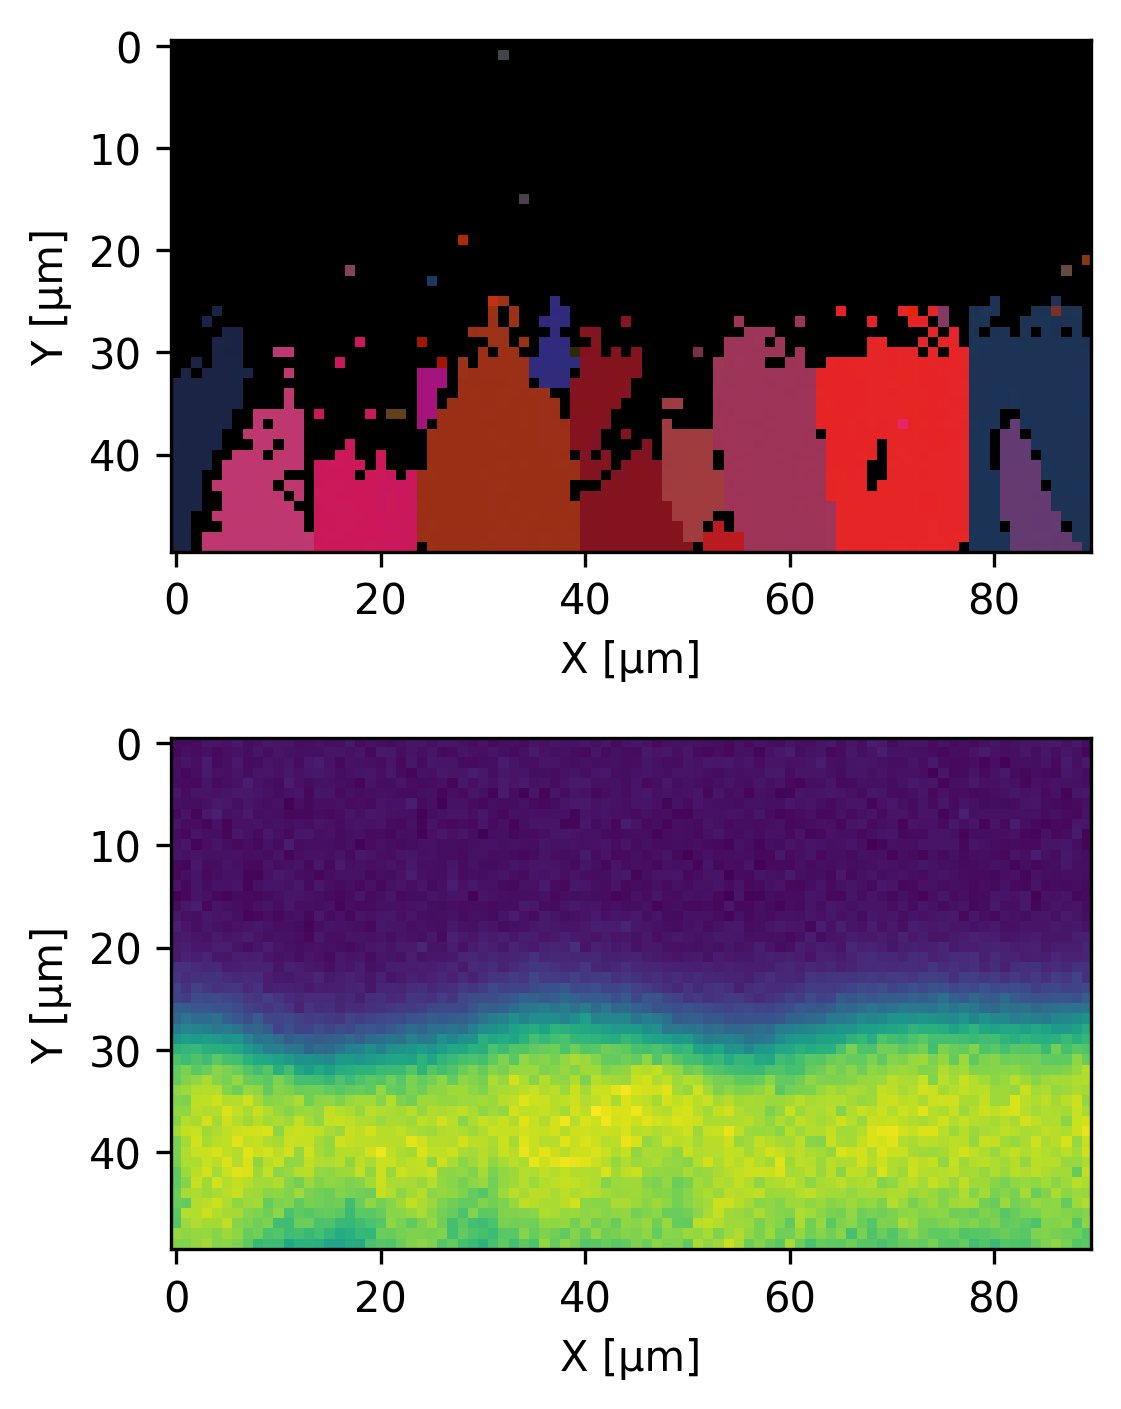

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
import matplotlib.colors as colors

fig, axs = plt.subplots(2,1,dpi=300)
f = h5py.File(data_folder+sorted_files[4], 'r')

axs[0].set_xlabel("X [μm]")
axs[1].set_xlabel("X [μm]")
axs[0].set_ylabel("Y [μm]")
axs[1].set_ylabel("Y [μm]")

axs[0].invert_yaxis()
axs[1].invert_yaxis()

image_resolution = (f['1/EDS/Header/X Cells'][0],f['1/EDS/Header/Y Cells'][0])
crop = slice(15, 65),slice(15, 105)

data = np.array(f['1/EBSD/Data/Euler']).reshape(image_resolution[1],image_resolution[0],3)

data = np.flip(data,axis=0)

data = data[crop]

data[:,:,0] = data[:,:,0]/(2*np.pi)
data[:,:,1] = data[:,:,1]/(np.pi)
data[:,:,2] = data[:,:,2]/(np.pi)

ref_data = data


map1 = axs[0].imshow(data)
#c = fig.colorbar(map1, ax=axs)

#axs[0].set_xlim(0,f['1/EBSD/Header/Bounding Box Size'][0])
#axs[0].set_ylim(0,f['1/EBSD/Header/Bounding Box Size'][1])



data = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])

data = np.flip(data,axis=0)

data = data[crop]

map2 = axs[1].imshow(data)

fig.tight_layout()


In [19]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift, gaussian_filter


Sn_cube = np.zeros((ref_data.shape[0],ref_data.shape[1],len(sorted_files)))
Nb_cube = np.zeros((ref_data.shape[0],ref_data.shape[1],len(sorted_files)))
euler_cube = np.zeros((ref_data.shape[0],ref_data.shape[1],len(sorted_files),3))

#shifts = np.zeros((len(sorted_files),2),dtype='int32')
#shifts[25:] += np.array((17,0))
#shifts[28] += np.array((-8,0))

reference_image = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])

def update(frame):
    file = sorted_files[frame]

    f = h5py.File(data_folder+file, 'r')

    SE_name = np.array(f['1/Electron Image/Data/SE/'])[0]
    SE = np.array(f['1/Electron Image/Data/SE/'+SE_name]).reshape(352,512)
    
    #shift, error, diffphase = phase_cross_correlation(reference_image,SE)
    #shift /= 352/image_resolution[1]
    #shift = shift[0:1].astype('int')
    #shift = np.array((0,0))

    euler_data = np.array(f['1/EBSD/Data/Euler']).reshape(image_resolution[1],image_resolution[0],3)
    # euler_data[:,:,0] = euler_data[:,:,0]/(2*np.pi)
    # euler_data[:,:,1] = euler_data[:,:,1]/(np.pi)
    # euler_data[:,:,2] = euler_data[:,:,2]/(np.pi)

    Sn_data = np.array(f['1/EDS/Data/Window Integral/Sn Lα1']).reshape(image_resolution[1],image_resolution[0])
    Nb_data = np.array(f['1/EDS/Data/Window Integral/Nb Lα1']).reshape(image_resolution[1],image_resolution[0])

    shift, error, diffphase = phase_cross_correlation(reference_image,Sn_data,normalization=None)
    shift = shift.astype('int')

    euler_data = np.roll(euler_data,shift,axis=(0,1))
    Sn_data = np.roll(Sn_data,shift,axis=(0,1))
    Nb_data = np.roll(Nb_data,shift,axis=(0,1))

    euler_data = euler_data[crop]
    Sn_data = Sn_data[crop]
    Nb_data = Nb_data[crop]

    Sn_cube[:,:,frame] = Sn_data
    Nb_cube[:,:,frame] = Nb_data
    euler_cube[:,:,frame,:] = euler_data

    map1.set_array(euler_data)
    map1.set_extent((0,euler_data.shape[1]*0.1,0,euler_data.shape[0]*0.1))

    map2.set_array(Sn_data)
    map2.set_extent((0,Sn_data.shape[1]*0.1,0,Sn_data.shape[0]*0.1))

    axs[0].set_xlim(0,euler_data.shape[1]*0.1)
    axs[0].set_ylim(0,euler_data.shape[0]*0.1)
    axs[0].set_title(f'Z = {round(0.1*frame,1)} μm')

    return (map1,map2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=len(sorted_files), interval=30)

ani.save('test.gif', fps = 2) 

MovieWriter ffmpeg unavailable; using Pillow instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.281143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.281143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.73553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.7242756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.2607265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.720571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

In [20]:
ind = np.indices(euler_cube.shape[:3])
coord_cube = np.stack((ind[0]*0.1,ind[1]*0.1,ind[2]*0.1),axis=-1)

np.save('./output/coord_cube.npy',coord_cube)
np.save('./output/Sn_cube.npy',Sn_cube)
np.save('./output/Nb_cube.npy',Nb_cube)
np.save('./output/euler_cube.npy',euler_cube)